Face-Generation using GAN

In this project, we train a DCGAN on CelebFaces Attributes (CelebA) Dataset.We therefore train a generator network tha helps to generate new images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You'll be using the CelebFaces Attributes Dataset (CelebA) to train your adversarial networks.
Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy image.
The dataset can be downloaded from this [Link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)


In [2]:
# Unzipping the processed-celeba-small zip
!unzip  "/content/drive/MyDrive/processed-celeba-small.zip"

Streaming output truncated to the last 5000 lines.
  inflating: processed_celeba_small/celeba/New Folder With Items/052332.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  
  inflating: 

In [3]:
data_dir = 'processed_celeba_small/'

In [4]:
# Installing Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
%matplotlib inline

Visualize the CelebA Data - The CelebA dataset contains over 200,000 celebrity images with annotations. These images are basically colour images that have 3 color channels (RGB) each.Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images

Your images should be square, Tensor images of size image_size x image_size in the x and y dimension.
Your function should return a DataLoader that shuffles and batches these Tensor images.


In [5]:
!pip install torch torchvision

In [6]:
# import necessary libraries
import torch
from torchvision import datasets
from torchvision import transforms

In [7]:
# Batch neural network using dataloader
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    batch_size: The size of each batch; the number of images in a batch
    img_size: The square size of the image data (x, y)
    data_dir: Directory where image data is located
    """
    transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()]) 
    image_dataset = datasets.ImageFolder(data_dir, transform = transform)
    return torch.utils.data.DataLoader(image_dataset, batch_size = batch_size, shuffle=True)


In [8]:
batch_size = 64 # hyperparameter
img_size = 32
# dataloader with batch_size and img_size
celeba_train_loader = get_dataloader(batch_size, img_size)

Converting the Tensor Images into NumPy type and then transposing the dimension to dsiplay the image

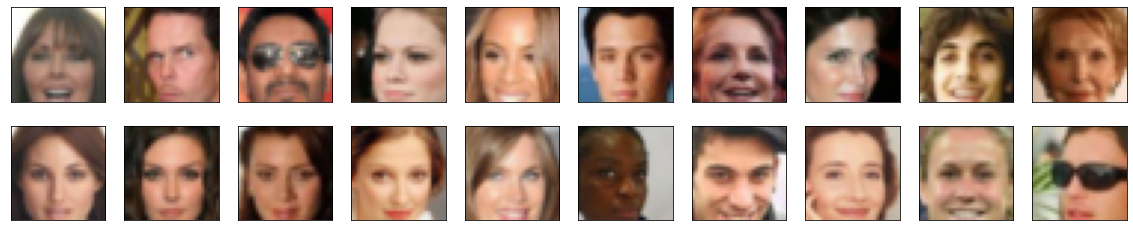

In [9]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(celeba_train_loader)
images, _ = dataiter.next()

# Plotting the images from a batch
fig = plt.figure(figsize=(20,4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [10]:
# Scaling the image to range of -1 to 1 (Asuumption - input x is scaled from 0-1)
def scale(x, feature_range=(-1, 1)):
    min , max = feature_range
    x =  x * (max - min) + min
    return x

In [11]:
img = images[0]
scaled_img = scale(img)
print('Min: ', scaled_img.min()) # check the range of the scaled img to be around -1 to 1
print('Max: ', scaled_img.max())

Min:  tensor(-0.7569)
Max:  tensor(1.)


Defining the Model
A GAN is comprised of two adversarial networks, a discriminator and a generator respectively.


Discriminator :  

---
The discriminator is a convolutional classifier without max-pooling layers.The inputs to the discriminator are 32x32x3 tensor images and the output results in a single value indicating the image to be real or fake.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
def conv (in_channels, out_channels, kernel_size, stride=2, padding=1,  batch_norm = True):
  layers =[]
  layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False))
  if (batch_norm):
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

In [14]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        conv_dim - Depth of first convolutinal layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim =conv_dim
        self.conv1 = conv (3, conv_dim, 4,  batch_norm= False) # 3 conv layer followed by fully-connected layer
        self.conv2 = conv (conv_dim, conv_dim*2, 4)
        self.conv3 = conv (conv_dim*2, conv_dim*4, 4)
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

 
    def forward(self, x):
        """
        x - The input to the neural network
        returns the discriminator logits(output)
        """

        y = F.leaky_relu(self.conv1(x), 0.2)
        y = F.leaky_relu(self.conv2(y), 0.2)
        y = F.leaky_relu(self.conv3(y), 0.2)
        out = y.view(-1, self.conv_dim*4*4*4) # flattening
        
        out = self.fc(out) # output layer       
        return out


Generator
---
They help GAN learn to ceate fake data by including feedback from the discriminator and help discriminator to classify real output.They upsample an input and generate a new image of the same size as our training data 32x32x3. Thee inputs are vectors of some length z_size while the output is an image of shape 32x32x3

In [15]:
def deconv (in_channels, out_channels, kernel_size, stride=2, padding=1,  batch_norm = True):
  layers =[]
  layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False))
  if(batch_norm):
    layers.append(nn.BatchNorm2d(out_channels))

  return nn.Sequential(*layers)

In [16]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        z_size - Length of the input latent vector z
        conv_dim - Depth of the input to the lats tanspose conv layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc2 = nn.Linear(z_size, conv_dim*4*4*4)
        self.t_conv1 = deconv (conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv (conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv (conv_dim, 3, 4, batch_norm= False)

    def forward(self, x):
        """
        x - input
        output - 32x32x3 tensor image
        """
        y = self.fc2(x)
        y = y.view(-1,self.conv_dim*4, 4,4)

        z = F.relu(self.t_conv1(y)) 
        z = F.relu(self.t_conv2(z))
        z = torch.tanh(self.t_conv3(z))

        return z



Weight Initialization

---
Initialization of weights of conv and lin layer is done to ensure the model converges.In DCGAN (weight initialization) happens from zero centered normal distribution with standard deviation 0.02

In [17]:
def weights_init_normal(m):
    """
    Weights are obtained from N(0,0.02) distribution 
    m: layer    
    """
    classname = m.__class__.__name__
    if  hasattr(m, 'weight') and classname.find('Conv') or classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    

Building the complete network

In [18]:
# instantiate the discriminator and generator
def complete_network(d_conv_dim, g_conv_dim, z_size):
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    D.apply(weights_init_normal) # initialize the model weights
    G.apply(weights_init_normal)

    print(D)
    print(G)
    
    return D, G

In [19]:
# model hyperparamter
d_conv_dim = 64
g_conv_dim = 64
z_size = 100
D, G = complete_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)
Generator(
  (fc2): Linear(in_features=100, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [20]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu: # to ensure the training on GPU if available
    print('No GPU')
else:
    print('GPU Available.Training...')

GPU Available.Training...


Loss Calculation - Discriminator and Generative Loss

---

Discriminator - Total Loss = loss_real-img + loss_fake-img
For Discriminator ouput is 1 for real img and 0 for fake img
Generator Loss ensure that the discriminator produce real image

In [21]:
def real_loss(D_out):
    '''
    D_out - discriminator logits
    output real loss
    '''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*0.9  # one sided label smoothing
   
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss() # binary-cross entropy with logits loss
    loss = criterion(D_out.squeeze(), labels) # loss calculation
    return loss

def fake_loss(D_out):
    '''
    D_out: discriminator logits
    output - fake loss
    '''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels) # loss calculation
    return loss

In [22]:
import torch.optim as optim

# params
lr_d = 0.0002
lr_g = 0.0002
beta1= 0.5
beta2=0.999 #default
# Using Adam Optimizers
d_optimizer = optim.Adam(D.parameters(), lr_d, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr_g, [beta1, beta2])

Model Training

---
During training we alternate b/w discriminator and generator.

In [23]:
def train(D, G, n_epochs, print_every=50):
    '''
    D - the discriminator network
    G - the generator network
    n_epochs - number of epochs
    print_every - interval to print and record the models losses
    output - D and G loss
    '''
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # loss and generated "fake" sample
    losses = []
    samples = []
    
    # data for sampling is fixed -they are constant throughout training
    # Also help to inspect performance of model
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs): #epoch
        for batch_i, (real_images, _) in enumerate(celeba_train_loader): # batch train loop
            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
              real_images = real_images.cuda()
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            out_real = D(real_images)
            d_loss_real = real_loss(out_real)

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
              z = z.cuda()
            fake_out =G(z)

            out_fake = D(fake_out)
            d_loss_fake = fake_loss(out_fake)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
              z = z.cuda()
            fake_out_g = G(z)
            G_D_out = D(fake_out_g)

            g_loss = real_loss(G_D_out)
            g_loss.backward()

            g_optimizer.step()
            
            if (batch_i % print_every == 0): 
                losses.append((d_loss.item(), g_loss.item())) # append D and G loss
                # print the stats
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch+1, n_epochs, d_loss.item(), g_loss.item())) 

        G.eval() # generate samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    with open('train_samples.pkl', 'wb') as f: #pkl file
        pkl.dump(samples, f)

    return losses

In [24]:
n_epochs = 30 # number of epoch
losses = train(D, G, n_epochs=n_epochs) #Training

Epoch [    1/   30] | d_loss: 1.3875 | g_loss: 0.7072
Epoch [    1/   30] | d_loss: 0.6526 | g_loss: 1.5176
Epoch [    1/   30] | d_loss: 0.7043 | g_loss: 2.0585
Epoch [    1/   30] | d_loss: 0.7685 | g_loss: 2.0017
Epoch [    1/   30] | d_loss: 1.1154 | g_loss: 2.1906
Epoch [    1/   30] | d_loss: 0.9154 | g_loss: 1.7547
Epoch [    1/   30] | d_loss: 1.0023 | g_loss: 1.1981
Epoch [    1/   30] | d_loss: 1.1828 | g_loss: 0.8477
Epoch [    1/   30] | d_loss: 0.9241 | g_loss: 1.3098
Epoch [    1/   30] | d_loss: 0.9712 | g_loss: 1.2090
Epoch [    1/   30] | d_loss: 1.0733 | g_loss: 1.5931
Epoch [    1/   30] | d_loss: 1.1850 | g_loss: 0.6806
Epoch [    1/   30] | d_loss: 1.0883 | g_loss: 1.2494
Epoch [    1/   30] | d_loss: 1.0954 | g_loss: 1.3609
Epoch [    1/   30] | d_loss: 1.1645 | g_loss: 0.9669
Epoch [    1/   30] | d_loss: 1.1659 | g_loss: 1.3501
Epoch [    1/   30] | d_loss: 1.1175 | g_loss: 1.3316
Epoch [    1/   30] | d_loss: 1.3301 | g_loss: 0.9509
Epoch [    1/   30] | d_loss

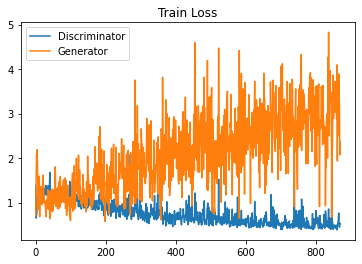

In [25]:
# Plotting the discriminator and generator loss after each epoch
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Train Loss")
plt.legend()

Generate Sample from Training

In [26]:
# Viewing list of passed from samples
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(20,4), nrows=2, ncols=8, sharex=True,sharey=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

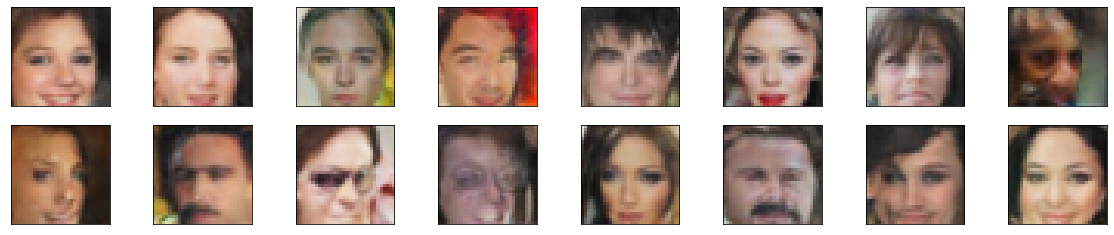

In [27]:
with open('train_samples.pkl', 'rb') as f: 
    samples = pkl.load(f)
v_s = view_samples(-1, samples)

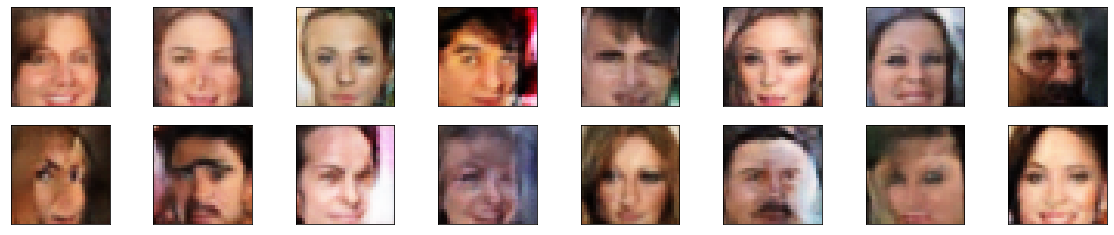

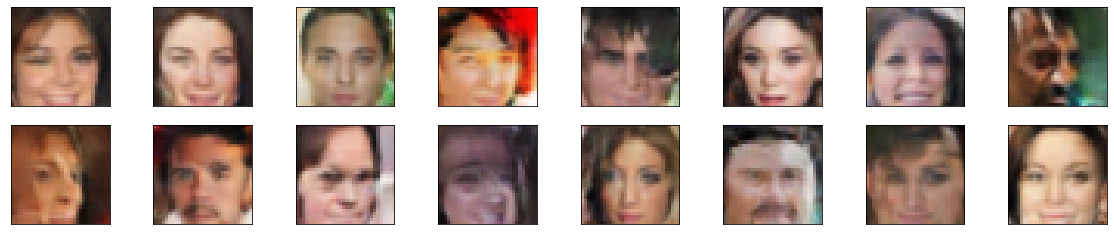

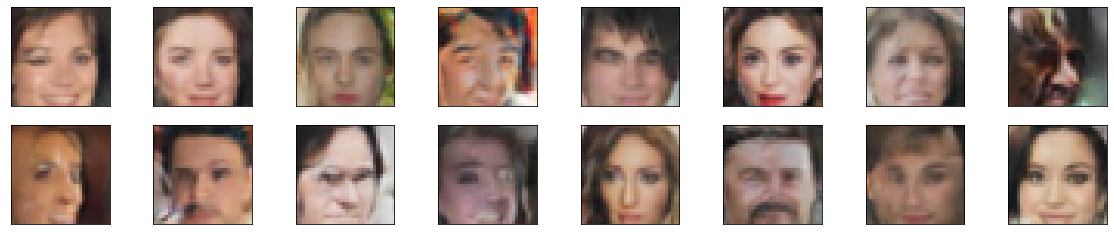

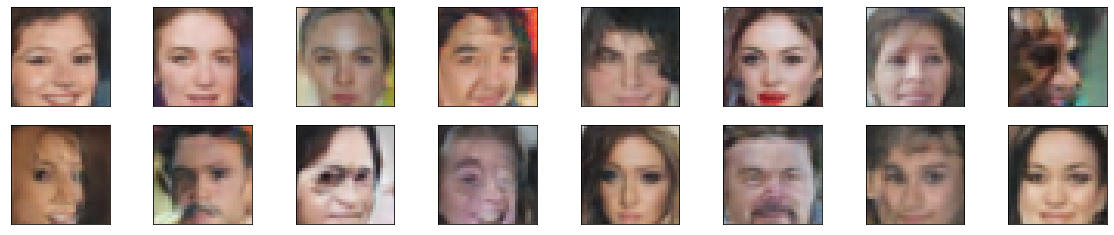

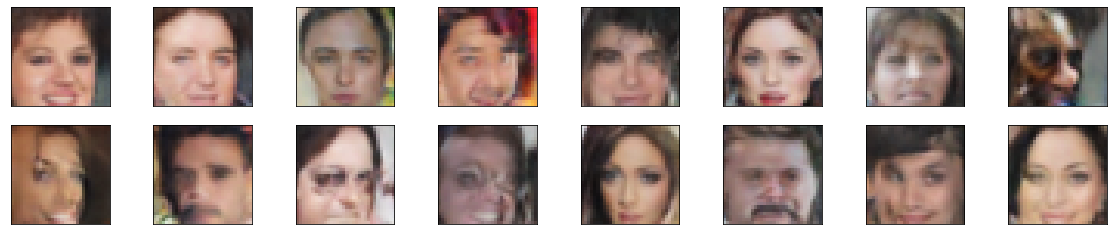

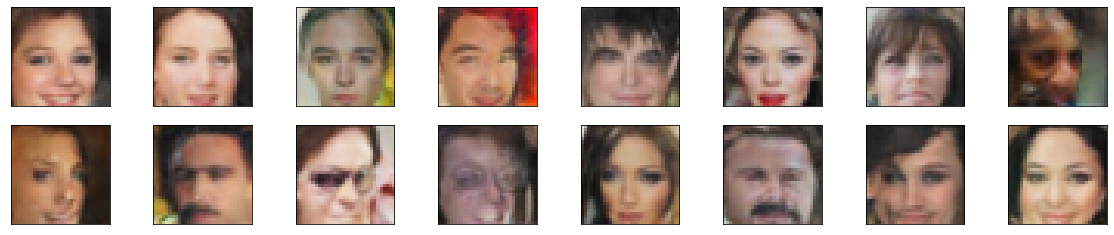

In [28]:
for i in range(4, 30, 5):
    v_s_1 = view_samples(i, samples)
    print()